In [2]:
#Imort needed packages

import datetime
import pathlib
import yaml

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from PIL import Image

# Load constantes

In [3]:
with open("../config.yaml",'r') as config_file:
    Config = yaml.safe_load(config_file)

    #Transform path string into path
    Config["DATA_DIR"] = pathlib.Path(Config["DATA_DIR"])
    Config["MODELS_DIR"] = pathlib.Path(Config["MODELS_DIR"])


# Functions

In [16]:
def build_image_database(path,target):
    """    Build a pandas dataframe with target class and access path to images.

    Parameters:
        - path (Path): Path pattern to read csv file containing images information
        - target(str): The second column to extract from the file

    Return:
        A pandas dataframe,
    -------
    """
    #Load file
    _df= pd.read_csv(path,
            names=["all"],
        )
    #Recover data
    _df["image_id"]=_df["all"].apply(lambda x: x.split(' ')[0])
    _df[target]=_df["all"].apply(lambda x: ' '.join(x.split(' ')[1:]))
    _df[target].unique()

    #Create path
    _df["path"]= _df['image_id'].apply( lambda x: Config["DATA_DIR"]/"images"/(x+'.jpg')) 
    
    return _df.drop(columns=["all"])

In [17]:
def build_classification_model(df: pd.DataFrame,target: str, images: str):
    """Build a tensorflow model using information from target and images columns in dataframes
    Parameters
    ----------
        - df (pandas.dataFrame): dataframe with target and images columns
        - target (str): column name for target variable
        - images (str): column name for images
    Returns
    ------
    tensorflow model built & compiled
    """
    
    #Compute number of classes for output layer
    nb_classes = df[target].nunique()
    
    # Computer images size for input layer
    size = df[images].iloc[0].shape
    
    # Building the model
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(nb_classes , activation='softmax'))

    #Compilation of the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #output layer of nb_classes
    
    return model

In [18]:
def show_image(df,row,target):
    """show the image in the ligne row and the associated target column

    Args:
        df (pandas.dataFrame): the dataframe of images
        row (int): the index of the row
        target (string): the column name of the associated label
    Return
    ------
    None
    """

    assert target in df.columns, f"Column {target} not found in dataframe"
    assert 'path' in df.columns, f"Column path doens't not exit in dataframe"
    _img = plt.imread(df.loc[row,'path'])
    print(df.loc[row,target])
    plt.imshow(_img)
    return

In [19]:
def load_resize_image(path,height,width):
    """Load an image and resize it to the target size

    Parameters:
        - path (Path): path to the file to load and resize
        - height (int): the height of the final resized image
        - width(int): the width of the resized image 
    Return
    ------
    numpy.array containing resized image
    """
    return np.array(Image.open(path).resize((width,height)))

In [20]:
def build_x_and_y(df: pd.DataFrame, target: str, images: str, stratify: str=None):
    """build x tensor and y tensor for model fitting.
    parameters
    ----------
    df(pd.DataFrame): dataframe 
    target(str): name of target column
    images (str): name of resized images column
        
    Returns
    -------
    
    x (numpy.array): tensor of x values
    y (numpy.array): tensor of y values
    """
    
    x= np.array(df[images].to_list())
    y=tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
    return x,y

In [40]:
def classify_images(images,model,classes_names=None)->int:
    """Classify images through a tensorflow model.
    
    Parameters:
    -----------
    
    images(np.array): set of images to classify
    model (tensorflow.keras.Model): tensorflow/keras model
    
    Returns
    -------
    predicted classes 
    
    """
    
    results = model.predict(images)
    classes_values = np.argmax(results,axis=1)
    if classes_names is not None:
        classes = np.array(classes_names[classes_values])
    return classes

In [41]:
def save_model(model ,saving_dir,basename="model",append_time=False):
  """Save tf/Keras model in saving_dir folder

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename (str): the basename of the model
  append_time (bool): indicate if the time will be append to the basename
  saving_dir (path): location to save model file
  """
  model.save( f"{saving_dir}/{basename}{'_' + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') if append_time   else ''}.h5")
  return

# Read train & test file

In [24]:
manufacturer_train_df = build_image_database(Config["DATA_DIR"]/"images_manufacturer_train.txt","manufacturer")
manufacturer_test_df = build_image_database(Config["DATA_DIR"]/"images_manufacturer_test.txt","manufacturer")

In [25]:
# Previous the dataframe 
manufacturer_train_df.head()

,image_id,manufacturer,path
0,1025794,Boeing,../dataset/data/images/1025794.jpg
1,1340192,Boeing,../dataset/data/images/1340192.jpg
2,0056978,Boeing,../dataset/data/images/0056978.jpg
3,0698580,Boeing,../dataset/data/images/0698580.jpg
4,0450014,Boeing,../dataset/data/images/0450014.jpg


In [26]:
manufacturer_test_df.head()

,image_id,manufacturer,path
0,1514522,Boeing,../dataset/data/images/1514522.jpg
1,0747566,Boeing,../dataset/data/images/0747566.jpg
2,1008575,Boeing,../dataset/data/images/1008575.jpg
3,0717480,Boeing,../dataset/data/images/0717480.jpg
4,0991569,Boeing,../dataset/data/images/0991569.jpg


# View some images

Boeing


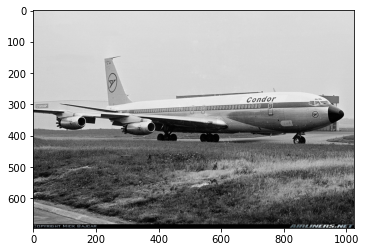

In [27]:
show_image(manufacturer_train_df, 0, 'manufacturer')

Boeing


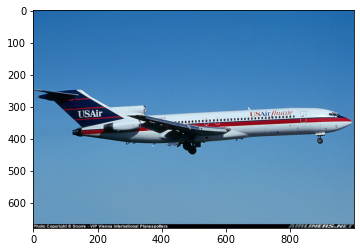

In [28]:
show_image(manufacturer_test_df,42,"manufacturer")

# Resize Images

In [29]:
#Resize train images
manufacturer_train_df['resized_image'] = manufacturer_train_df.apply(
        lambda r: load_resize_image(r['path'],Config["IMAGE_HEIGHT"],Config["IMAGE_WIDTH"]),
        axis=1)
#Resize test images
manufacturer_test_df['resized_image'] = manufacturer_test_df.apply(
    lambda r: load_resize_image(r['path'],Config["IMAGE_HEIGHT"],Config["IMAGE_WIDTH"]),
    axis=1)

# Split dataset into x and y

In [30]:
X_train,y_train = build_x_and_y(manufacturer_train_df,'manufacturer','resized_image')
X_test,y_test = build_x_and_y(manufacturer_test_df,'manufacturer','resized_image')

# Build & train the model

In [31]:
model = build_classification_model(manufacturer_train_df,"manufacturer","resized_image")

2022-04-06 21:40:44.310507: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-06 21:40:44.311867: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 21:40:44.312483: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [32]:
%load_ext tensorboard

!rm -rf ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2022-04-06 21:40:44.667233: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-06 21:40:44.667548: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-06 21:40:44.668229: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [33]:
%%time 
epochs = 30
history = model.fit(X_train,y_train,batch_size = 96,epochs = epochs , validation_data = (X_test,y_test),
                   callbacks=[tensorboard_callback]
                   )

2022-04-06 21:40:44.876416: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-06 21:40:44.900853: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2370380000 Hz


Epoch 1/30
 1/35 [..............................] - ETA: 1:44 - loss: 96.9359 - accuracy: 0.0104

2022-04-06 21:40:48.055496: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-06 21:40:48.055747: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/35 [>.............................] - ETA: 1:03 - loss: 167.5062 - accuracy: 0.0339

2022-04-06 21:40:49.963374: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-06 21:40:49.967992: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-06 21:40:49.972716: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220406-214044/train/plugins/profile/2022_04_06_21_40_49
2022-04-06 21:40:49.974063: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220406-214044/train/plugins/profile/2022_04_06_21_40_49/rich-pc.trace.json.gz
2022-04-06 21:40:49.983474: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220406-214044/train/plugins/profile/2022_04_06_21_40_49
2022-04-06 21:40:49.984682: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20220406-214044/train/plugins/profile/2022_04_06_2

35/35 [==============================] - 76s 2s/step - loss: 78.0367 - accuracy: 0.0794 - val_loss: 3.0731 - val_accuracy: 0.2166
Epoch 2/30
35/35 [==============================] - 73s 2s/step - loss: 3.0713 - accuracy: 0.1884 - val_loss: 3.0041 - val_accuracy: 0.2202
Epoch 3/30
35/35 [==============================] - 74s 2s/step - loss: 3.0166 - accuracy: 0.1947 - val_loss: 2.8610 - val_accuracy: 0.2190
Epoch 4/30
35/35 [==============================] - 74s 2s/step - loss: 2.9451 - accuracy: 0.2037 - val_loss: 2.7931 - val_accuracy: 0.2181
Epoch 5/30
35/35 [==============================] - 74s 2s/step - loss: 2.8182 - accuracy: 0.2071 - val_loss: 2.7567 - val_accuracy: 0.2280
Epoch 6/30
35/35 [==============================] - 74s 2s/step - loss: 2.7036 - accuracy: 0.2179 - val_loss: 2.7866 - val_accuracy: 0.2271
Epoch 7/30
35/35 [==============================] - 74s 2s/step - loss: 2.6289 - accuracy: 0.2314 - val_loss: 2.6836 - val_accuracy: 0.2307
Epoch 8/30
35/35 [============

In [23]:
%tensorboard  --logdir  logs/fit 

# Predict from the model

In [34]:
classes_names = manufacturer_train_df['manufacturer'].astype('category').cat.categories

In [35]:
classify_images(X_test[10:20],model,classes_names)

array(['Boeing', 'Embraer', 'Boeing', 'de Havilland', 'Embraer', 'Boeing',
       'Boeing', 'Boeing', 'Boeing', 'Boeing'], dtype=object)

# Save the model

In [39]:
save_model(model,Config["MODELS_DIR"],basename="tensor_model")